# Using pyLDAvis for Analysis for HIST-414 Alex R

Legal judgments are complex documents that draw upon many facets of legal reasoning, including the interpretation of applicable law, evaluation of evidence presented in court, and consideration of prior precedents. This makes them difficult to systemically analyze as they often defy single membership classification. Rice (2019) introduces Latent Dirichlet Allocation as a method of unsupervised structured topic modelling (STM), allowing for underlying themes in legal texts to be uncovered via a computational approach and capture the proportionate attention given to multiple legal dimensions within each judgement. A continuation of notebook 2 the goal of this notebook is to create interactive visualizations in order to explore and understand these relationships. 

In [ ]:
#Import packages 
import pandas as pd
import json
import pathlib
import re, string
import multiprocessing
import requests

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import multiprocessing

Explanation of LDA from notebook 2 or if this is attached to notebook 2 then this is unnecessary 

### 1. Load the data

The data we will be using is the Supreme Court of Canada Bulk Decisions Dataset which contains the full text of Supreme Court of Canada decisions.

In [13]:
#Get the data from Github (Same step as in notebook 2 just done differently can pick best one)

start_year = 1877  # First year of data sought (1877+)
end_year = 2024  # Last year of data sought (2024 -)

# Load data directly from GitHub repository
base_url = 'https://raw.githubusercontent.com/Refugee-Law-Lab/scc_bulk_data/master/DATA/YEARLY/'
results = []

# load data (all years, json files)
print(f"Loading data from {start_year} to {end_year}...")
for year in range(start_year, end_year+1):
    try:
        url = base_url + f'{year}.json'
        response = requests.get(url)
        if response.status_code == 200:
            results.extend(response.json())
            print(f"Loaded {year} ✓")
    except Exception as e:
        print(f"Error loading {year}: {e}")

# Convert to dataframe
df = pd.DataFrame(results)
print(f"\nTotal records loaded: {len(df)}")
df.head()


Loading data from 1877 to 2024...
Loaded 1877 ✓
Loaded 1878 ✓
Loaded 1879 ✓
Loaded 1880 ✓
Loaded 1881 ✓
Loaded 1882 ✓
Loaded 1883 ✓
Loaded 1884 ✓
Loaded 1885 ✓
Loaded 1886 ✓
Loaded 1887 ✓
Loaded 1888 ✓
Loaded 1889 ✓
Loaded 1890 ✓
Loaded 1891 ✓
Loaded 1892 ✓
Loaded 1893 ✓
Loaded 1894 ✓
Loaded 1895 ✓
Loaded 1896 ✓
Loaded 1897 ✓
Loaded 1898 ✓
Loaded 1899 ✓
Loaded 1900 ✓
Loaded 1901 ✓
Loaded 1902 ✓
Loaded 1903 ✓
Loaded 1904 ✓
Loaded 1905 ✓
Loaded 1906 ✓
Loaded 1907 ✓
Loaded 1908 ✓
Loaded 1909 ✓
Loaded 1910 ✓
Loaded 1911 ✓
Loaded 1912 ✓
Loaded 1913 ✓
Loaded 1914 ✓
Loaded 1915 ✓
Loaded 1916 ✓
Loaded 1917 ✓
Loaded 1918 ✓
Loaded 1919 ✓
Loaded 1920 ✓
Loaded 1921 ✓
Loaded 1922 ✓
Loaded 1923 ✓
Loaded 1924 ✓
Loaded 1925 ✓
Loaded 1926 ✓
Loaded 1927 ✓
Loaded 1928 ✓
Loaded 1929 ✓
Loaded 1930 ✓
Loaded 1931 ✓
Loaded 1932 ✓
Loaded 1933 ✓
Loaded 1934 ✓
Loaded 1935 ✓
Loaded 1936 ✓
Loaded 1937 ✓
Loaded 1938 ✓
Loaded 1939 ✓
Loaded 1940 ✓
Loaded 1941 ✓
Loaded 1942 ✓
Loaded 1943 ✓
Loaded 1944 ✓
Loaded 1945 ✓


,citation,citation2,dataset,year,name,language,document_date,source_url,scraped_timestamp,unofficial_text,other
0,(1877) 1 SCR 110,,SCC,1877,Boak et al. v. The Merchant's Marine Insurance...,en,1877-01-23,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Boak et al. v. The Merchant's Marine Insurance...,
1,(1877) 1 SCR 114,,SCC,1877,Smyth v. McDougall,en,1877-02-01,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Smyth v. McDougall\nCollection\nSupreme Court ...,
2,(1877) 1 SCR 117,,SCC,1877,The Queen v. Laliberté,en,1877-02-03,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,The Queen v. Laliberté\nCollection\nSupreme Co...,
3,(1877) 1 SCR 145,,SCC,1877,Brassard et al. v. Langevin,en,1877-02-28,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Brassard et al. v. Langevin\nCollection\nSupre...,
4,(1877) 1 SCR 235,,SCC,1877,Johnstone v. The Minister & Trustees of St. An...,en,1877-06-28,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Johnstone v. The Minister & Trustees of St. An...,


In [ ]:
# download extra datasets to clean our supreme court data
nltk.download('stopwords') #list of stop words english and french
nltk.download('wordnet') #wordnet dataset for lemmatization 
nltk.download('omw-1.4') #multilingual support for French mostly

# Initialize lemmatizer and stopwords
LEMMA = WordNetLemmatizer()
en_stop = set(stopwords.words('english'))
fr_stop = set(stopwords.words('french'))
custom_stop = {'from', 'subject', 're', 'edu', 'thereof', 'herein',
               'hereby', 'aforesaid', 'whereas', 'shall', 'henceforth',
               'article', 'section', 'v'}
stop_words = en_stop | fr_stop | custom_stop #make a custom set of stop words


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alexr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 2. Main cleaning Stage  
This is the same as in notebook 2, but in one cell for clarity as we are repeating analysis. More concretely we are cleaning the data with these steps:
1. Lowercases all text 
2. Removes newlines/extra spaces 
3. Remove punctuation 
4. Tokenizes with Gensim's simple_preprocess 
5. Filters stopwords (See above cell stopword set)
6. Applies WordNet lemmatization (See above lemmatization dataset)

Next we make a fuinction that finds Bigrams (which are consecutive written units in this case words). After that we make a function to construct a document-term matrix. Finally we define a function to train the model. 

In [ ]:
#Step 2
#Clean the text
def preprocess_texts(df, text_col="unofficial_text", stop_words=stop_words, lemmatize=True):
    """
    Tokenize, remove stopwords/punctuation, and optionally lemmatize the texts 
    Returns list of token lists
    """
    texts = df[text_col].astype(str).tolist()
    lemmatizer = WordNetLemmatizer()
    processed = []
    
    for doc in texts:
        tokens = []
        text = doc.lower().replace("\n", " ")
        text = re.sub(r"\s+", " ", text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        for token in simple_preprocess(text, deacc=True, min_len=3):
            if token not in stop_words:
                if lemmatize:
                    token = lemmatizer.lemmatize(token)
                tokens.append(token)
        processed.append(tokens)
    return processed

#Find bigrams Function
def make_bigrams(tokenized_texts, min_count=10, threshold=50):
    """
    Fit a bigram phraser and apply to tokenized texts
    """
    phrases = Phrases(tokenized_texts, min_count=min_count, threshold=threshold)
    bigram_mod = Phraser(phrases)
    return [bigram_mod[doc] for doc in tokenized_texts]

#document-term matrix
def create_dictionary_corpus(texts, no_below=15, no_above=0.5):
    """
    Build Gensim dictionary and corpus from tokenized texts
    """
    id2word = corpora.Dictionary(texts)
    id2word.filter_extremes(no_below=no_below, no_above=no_above)
    corpus = [id2word.doc2bow(text) for text in texts]
    return id2word, corpus

#Training Function
def train_lda(corpus, id2word, num_topics=25, passes=10, iterations=50):
    """
    Train LDA model
    """
    workers = max(1, multiprocessing.cpu_count()-1)
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=1975,
        chunksize=20000,
        passes=passes,
        iterations=iterations,
        eval_every=None,
        workers=workers,
        alpha='asymmetric',
        eta='auto',
        per_word_topics=False
    )
    return lda_model

In [ ]:
print("\nDataframe columns:")
print(df.columns.tolist())
print("\nFirst row sample:")
print(df.iloc[0].to_dict())


Dataframe columns:
['citation', 'citation2', 'dataset', 'year', 'name', 'language', 'document_date', 'source_url', 'scraped_timestamp', 'unofficial_text', 'other']

First row sample:
{'citation': '(1877) 1 SCR 110', 'citation2': '', 'dataset': 'SCC', 'year': 1877, 'name': "Boak et al. v. The Merchant's Marine Insurance Company", 'language': 'en', 'document_date': '1877-01-23', 'source_url': 'https://decisions.scc-csc.ca/scc-csc/scc-csc/en/item/14747/index.do', 'scraped_timestamp': '2022-08-31', 'unofficial_text': 'Boak et al. v. The Merchant\'s Marine Insurance Company\nCollection\nSupreme Court Judgments\nDate\n1877-01-23\nReport\n(1877) 1 SCR 110\nJudges\nRitchie, William Johnstone; Strong, Samuel Henry; Taschereau, Henri-Elzéar; Fournier, Télesphore; Henry, William Alexander\nOn appeal from\nNova Scotia\nSubjects\nAppeal\nDecision Content\nSupreme Court of Canada\nBoak, et al. v. The Merchants\' Marine Insurance Co. (1877) 1 SCR 110\nDate: 1877-01-23\nRobert Boak, et al.\nAppellant

In [ ]:
#Step 3 - Here we run our functions from above
#Might be computationally intensive (16m 7s)

# check text collumns
print("Available columns in dataframe:")
print(df.columns.tolist())

# Use the appropriate text column (in this case unofficial_text)
text_column = 'unofficial_text' 

# Preprocess texts
print("Preprocessing texts...")
tokenized_texts = preprocess_texts(df, text_col=text_column)

# Create bigrams
print("Creating bigrams...")
bigrams_list = make_bigrams(tokenized_texts)

# Create dictionary and corpus
print("Creating dictionary and corpus...")
id2word, corpus = create_dictionary_corpus(bigrams_list)

# Train LDA model - 
print("Training LDA model...")
lda = train_lda(corpus, id2word, num_topics=25)

print("LDA model training complete!")
print(f"Number of topics: {lda.num_topics}")
print(f"Corpus size: {len(corpus)}")
print(f"Dictionary size: {len(id2word)}")


Available columns in dataframe:
['citation', 'citation2', 'dataset', 'year', 'name', 'language', 'document_date', 'source_url', 'scraped_timestamp', 'unofficial_text', 'other']
Preprocessing texts...
Creating bigrams...
Creating dictionary and corpus...
Training LDA model...
LDA model training complete!
Number of topics: 25
Corpus size: 15707
Dictionary size: 58426


### 3. Optimal Number of Topics
In order to have a optimized model we will evaluate the amount of topics to use in the analysis. We will do this by evaluating model quality across a range of topic counts. The metric we will use is called coherence score, which measures how interpretable and semantically meaningful the topics are. Higher scores mean that the topics will make more sense to humans. 

Why do we do this as opposed to just training the model? Picking too few topics can make the themes too broad and uninformative, while too many topics can make them fragmented and incoherent. Here we have an empirical metric we can loook at to determine the best count. 


In [7]:
#Compute coherence values 
def compute_coherence_values(corpus, id2word, texts, start=5, limit=30, step=5):
    coherences = []
    model_list = []
    for num in range(start, limit+1, step):
        model = train_lda(corpus, id2word, num_topics=num)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())
    return model_list, coherences


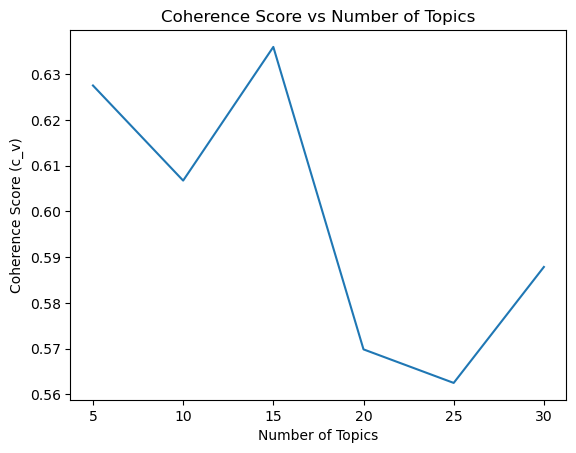

Optimal number of topics: 15 with coherence score: 0.635949235020093


In [ ]:
#Find the optimal amount of topics using function from above
#Computatiponally intensive (48m 28s)
model_list, coherences = compute_coherence_values(corpus, id2word, bigrams_list, start=5, limit=30, step=5)

import matplotlib.pyplot as plt

x = range(5, 31, 5)
plt.plot(x, coherences)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Select the model with the highest coherence
optimal_index = coherences.index(max(coherences))
optimal_model = model_list[optimal_index]
optimal_num_topics = x[optimal_index]
print(f"Optimal number of topics: {optimal_num_topics} with coherence score: {coherences[optimal_index]}")


We are looking the amount of topics with the highest coherence score which we can determine with the graph above. Our code looks for models from 5, 10, 15, 20, 25, and 30 topics and plots them. In this case it is 15, as it has the highest coherence score. 

### 4. pyLDAvis visualizaiton

Now we will make our interactive visualizaion of our topic model using the package pyLDAvis. This package is made specifically for LDA (Latent Dirichlet Allocation). 

"pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization." [Read More about pyLDAvis](https://pypi.org/project/pyLDAvis/). 

In [ ]:
#We can delete this cell for the final 
# Install pyLDAvis if not already installed
!pip install pyldavis

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


In [ ]:
#Basic visualization without optimal topic count (Lower down we have one with optimal count this one can be deleted)
def create_interactive_topic_visualization(lda_model, corpus, id2word, save_html=False, filename='lda_visualization.html'):
    """
    Create an interactive pyLDAvis visualization for the LDA model
    Parameters:
    - lda_model: Trained Gensim LDA model
    - corpus: Document-term matrix
    - id2word: Gensim dictionary
    """
    
    # Enable pyLDAvis for notebook display
    pyLDAvis.enable_notebook()
    
    # Prepare the visualization data
    vis_data = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
    
    # Display the visualization
    if save_html:
        # Save as standalone HTML file
        pyLDAvis.save_html(vis_data, filename)
        print(f"Interactive visualization saved as '{filename}'")
        print("You can open this file in any web browser to view the interactive visualization.")
    
    # Return the visualization object for display in notebook
    return vis_data

# Create and display the interactive visualization
interactive_vis = create_interactive_topic_visualization(
    lda_model=lda, 
    corpus=corpus, 
    id2word=id2word, 
    save_html=True,
    filename='supreme_court_topics_basic.html'
)

# Print
interactive_vis

Preparing visualization data...
Interactive visualization saved as 'supreme_court_topics_interactive.html'
You can open this file in any web browser to view the interactive visualization.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.034986  0.123090       1        1   0.279708
1      0.291804  0.070562       2        1   4.857821
2     -0.243531  0.020912       3        1   8.104797
3      0.289570 -0.027102       4        1  15.767821
4     -0.257378 -0.055109       5        1   9.946282
5      0.137540 -0.156571       6        1   2.030602
6     -0.131121 -0.140754       7        1   1.913651
7     -0.160433 -0.076404       8        1   2.573478
8     -0.003996  0.003571       9        1   0.007112
9     -0.014725  0.033222      10        1   0.067903
10     0.061416 -0.106602      11        1   0.862850
11     0.311404  0.040388      12        1  19.163060
12     0.030801  0.013317      13        1   0.001486
13    -0.032476 -0.020809      14        1   0.340799
14     0.006961  0.007818      15        1   0.018941
15    -0.250129  0.107977      16        1   8.624691
16     0.284483 -0.043594      17        1   4.899086
17     0.036887  0.012298      18        1   0.001828
18    -0.010380  0.027319      19        1   0.003101
19    -0.259989 -0.065434      20        1   8.987413
20     0.017888  0.012641      21        1   0.000732
21     0.132709  0.124330      22        1   0.405142
22     0.022421  0.020077      23        1   0.000678
23    -0.243757  0.113194      24        1  11.057589
24     0.019018 -0.038338      25        1   0.083430, topic_info=           Term           Freq          Total Category  logprob  loglift
2295       juge  241006.000000  241006.000000  Default  30.0000  30.0000
1549       cour  183660.000000  183660.000000  Default  29.0000  29.0000
2400        loi  141148.000000  141148.000000  Default  28.0000  28.0000
1757      droit  174414.000000  174414.000000  Default  27.0000  27.0000
1359      cette  163250.000000  163250.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
79    plaintiff      92.537470   71613.997231  Topic25  -6.0231   0.4375
1865       etre      94.693607  152311.312329  Topic25  -6.0000  -0.2941
390       civil      86.414891   36539.451222  Topic25  -6.0915   1.0419
2828     public      84.703950   91966.073089  Topic25  -6.1115   0.0989
2295       juge      76.166109  241006.990461  Topic25  -6.2178  -0.9707

[2142 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
47317      2  0.926315  acces_colere
47317     12  0.051462  acces_colere
47317     17  0.010292  acces_colere
4741       1  0.001196        access
4741       2  0.000855        access
...      ...       ...           ...
19651     10  0.002690        œuvres
19651     11  0.002690        œuvres
19651     12  0.055146        œuvres
19651     17  0.879651        œuvres
19651     20  0.001345        œuvres

[17207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [ ]:
# We extract topics for Lambda Values 
def extract_topic_terms_by_lambda(vis_data, lambda_value=0.6, num_terms=10):
    """
    Extract the most relevant terms for each topic at a specific lambda value
    
    Parameters:
    - vis_data: Prepared pyLDAvis data
    - lambda_value: Relevance metric (0 = most distinctive, 1 = most probable)
    - num_terms: Number of terms to extract per topic
    """
    all_topics = {}
    num_topics = len(vis_data.topic_coordinates)
    
    # Calculate relevance for each term in our topics
    for i in range(1, num_topics + 1):  
        topic_name = f'Topic{i}'
        topic_data = vis_data.topic_info[vis_data.topic_info.Category == topic_name].copy()
        
        # Calculate relevance score
        topic_data['relevance'] = (lambda_value * topic_data['logprob'] + 
                                  (1 - lambda_value) * topic_data['loglift'])
        
        # Get top terms by relevance
        top_terms = topic_data.sort_values(by='relevance', ascending=False).Term[:num_terms].values
        all_topics[f'Topic {i}'] = top_terms
    
    # Create a DataFrame
    topics_df = pd.DataFrame(all_topics).T
    topics_df.columns = [f'Term_{i+1}' for i in range(num_terms)]
    
    return topics_df

# Extract topic terms for different lambda values
print("Top terms by topic (Lambda = 0.1 - most distinctive):")
distinctive_terms = extract_topic_terms_by_lambda(interactive_vis, lambda_value=0.1)
print(distinctive_terms)

print("\nTop terms by topic (Lambda = 0.6 - balanced relevance):")
balanced_terms = extract_topic_terms_by_lambda(interactive_vis, lambda_value=0.6)
print(balanced_terms)

print("\nTop terms by topic (Lambda = 1.0 - most probable):")
probable_terms = extract_topic_terms_by_lambda(interactive_vis, lambda_value=1.0)
print(probable_terms)


Top terms by topic (Lambda = 0.1 - most distinctive):
                         Term_1                Term_2                 Term_3  \
Topic 1        delivered_orally              guenette          common_gaming   
Topic 2   homicide_involontaire                accuse                  jures   
Topic 3                employer  collective_agreement  collective_bargaining   
Topic 4                   impot            entreprise              arbitrage   
Topic 5                    land                   tax                 indian   
Topic 6               testament             testateur             testatrice   
Topic 7                     bia            bankruptcy               creditor   
Topic 8                election     election_petition  preliminary_objection   
Topic 9                    sawn                sawing                  wynne   
Topic 10        tobacco_product               tobacco            usage_tabac   
Topic 11             quasidelit                vandry       curley

In [ ]:
#Second attempt at visualization with optimal model 

def create_interactive_topic_visualization(lda_model, corpus, id2word, save_html=False, filename='lda_visualization.html'):
    """
    Create an interactive pyLDAvis visualization for the LDA model
    
    Parameters:
    - lda_model: Trained Gensim LDA model
    - corpus: Document-term matrix
    - id2word: Gensim dictionary
    - save_html: Whether to save as standalone HTML file
    - filename: Name for the HTML file if saving
    """
    
    # Enable pyLDAvis for notebook display (if using Jupyter)
    pyLDAvis.enable_notebook()
    
    # Prepare the visualization data
    print("Preparing visualization data...")
    vis_data = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
    
    # Display the visualization
    if save_html:
        # Save as standalone HTML file
        pyLDAvis.save_html(vis_data, filename)
        print(f"Interactive visualization saved as '{filename}'")
        print("You can open this file in any web browser to view the interactive visualization.")
    
    # Return the visualization object for display in notebook
    return vis_data

# Use your visualization function with the optimal model
interactive_vis = create_interactive_topic_visualization(
    lda_model=optimal_model,
    corpus=corpus,
    id2word=id2word,
    save_html=True,
    filename='supreme_court_topics_optimal.html'
)
interactive_vis

Preparing visualization data...
Interactive visualization saved as 'supreme_court_topics_interactive.html'
You can open this file in any web browser to view the interactive visualization.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.013327  0.137946       1        1   0.481318
1     -0.285311  0.107237       2        1   2.705825
2      0.207240  0.079907       3        1  19.031759
3     -0.323854 -0.043025       4        1  17.996321
4      0.219297 -0.063680       5        1  16.179243
5     -0.164960 -0.132355       6        1   3.007382
6      0.152767 -0.116216       7        1   3.531301
7      0.150047 -0.017140       8        1   4.272943
8     -0.038393 -0.004164       9        1   0.007140
9      0.153563  0.153727      10        1   1.867143
10     0.046329 -0.108584      11        1   2.166338
11    -0.345988  0.024320      12        1  24.021491
12    -0.068678 -0.003986      13        1   0.039551
13     0.157104  0.064517      14        1   3.825653
14     0.127508 -0.078504      15        1   0.866590, topic_info=       Term           Freq          Total Category  logprob  loglift
2295   juge  241613.000000  241613.000000  Default  30.0000  30.0000
1549   cour  191995.000000  191995.000000  Default  29.0000  29.0000
1147  appel  124425.000000  124425.000000  Default  28.0000  28.0000
2400    loi  143111.000000  143111.000000  Default  27.0000  27.0000
1862    ete  156681.000000  156681.000000  Default  26.0000  26.0000
...     ...            ...            ...      ...      ...      ...
471     day    1152.909740   29047.271998  Topic15  -5.8412   1.5217
958    term    1199.367508   47378.360528  Topic15  -5.8017   1.0720
64     loss    1117.961228   22818.228821  Topic15  -5.8720   1.7323
2588   paid    1094.191024   25506.658694  Topic15  -5.8935   1.5994
2052   good    1092.955478   26650.142054  Topic15  -5.8946   1.5545

[1370 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
35016      3  0.074513    abets
35016      5  0.018628    abets
35016      7  0.018628    abets
35016     14  0.856899    abets
9018       1  0.002234  ability
...      ...       ...      ...
40483     12  0.015855   zonage
40483     14  0.001441   zonage
7338       5  0.019271     ætna
7338       7  0.173439     ætna
7338      15  0.790110     ætna

[10959 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

## References

bmabey , and marksusol . “Pyldavis.” PyPI, 23 Apr. 2023, pypi.org/project/pyLDAvis/. 

Mattingly, W.J.B. “Introduction to Topic Modeling and Text Classification.” 1. Introduction to Topic Modeling - Introduction to Topic Modeling and Text Classification, Feb. 2021, topic-modeling.pythonhumanities.com/01_01_introduction_to_topic_modeling.html. 

“Supreme Court of Canada Bulk Decisions Dataset.” Refugee Law Lab - Refugee Law Lab, 27 June 2024, refugeelab.ca/bulk-data/scc/. 

Tran, Khuyen. “Pyldavis: Topic Modeling Exploration Tool.” Neptune.Ai, 20 May 2025, neptune.ai/blog/pyldavis-topic-modeling-exploration-tool. 

“What Is Pyldavis Library in Python?” HowDev, how.dev/answers/what-is-pyldavis-library-in-python. Accessed 9 June 2025. 
